# Algorithm

This is a Python implementation of Hankel temporal matrix factorization (HTMF).

In [8]:
import numpy as np

def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

def update_cg(var, r, q, Aq, rold):
    alpha = rold / np.inner(q, Aq)
    var = var + alpha * q
    r = r - alpha * Aq
    rnew = np.inner(r, r)
    q = r + (rnew / rold) * q
    return var, r, q, rnew

def ell_w(ind, W, X, rho = 1e+1):
    return X @ ((W.T @ X) * ind).T + rho * W

def conj_grad_w(sparse_mat, ind, W, X, maxiter = 5):
    rank, dim1 = W.shape
    w = np.reshape(W, -1, order = 'F')
    r = np.reshape(X @ sparse_mat.T - ell_w(ind, W, X), -1, order = 'F')
    q = r.copy()
    rold = np.inner(r, r)
    for it in range(maxiter):
        Q = np.reshape(q, (rank, dim1), order = 'F')
        Aq = np.reshape(ell_w(ind, Q, X), -1, order = 'F')
        w, r, q, rold = update_cg(w, r, q, Aq, rold)
    return np.reshape(w, (rank, dim1), order = 'F')

def ell_x(ind, W, X, F, gamma, rho = 1e+1):
    return W @ ((W.T @ X) * ind) + rho * X + gamma * X

def conj_grad_x(sparse_mat, ind, W, X, F, gamma = 1e+3, maxiter = 5):
    rank, dim2 = X.shape
    x = np.reshape(X, -1, order = 'F')
    r = np.reshape(W @ sparse_mat + gamma * F - ell_x(ind, W, X, F, gamma), -1, order = 'F')
    q = r.copy()
    rold = np.inner(r, r)
    for it in range(maxiter):
        Q = np.reshape(q, (rank, dim2), order = 'F')
        Aq = np.reshape(ell_x(ind, W, Q, F, gamma), -1, order = 'F')
        x, r, q, rold = update_cg(x, r, q, Aq, rold)
    return np.reshape(x, (rank, dim2), order = 'F')

def hankel(mat, d):
    dim1, dim2 = mat.shape
    col_num = dim2 - d + 1
    hmat = np.zeros((dim1 * d, col_num))
    for k in range(d):
        hmat[k * dim1 : (k + 1) * dim1, :] = mat[:, k : col_num + k]
    return hmat

def inv_hankel(hmat, rank, d):
    dim1, dim2 = hmat.shape
    temp = np.zeros((rank, d, dim2 + d - 1))
    for k in range(d):
        temp[:, k, k : dim2 + k] = hmat[k * rank : (k + 1) * rank, :]
    return np.true_divide(temp.sum(1), (temp != 0).sum(1))

def hard_thresholding(hmat, rank):
    u, s, v = np.linalg.svd(hmat, full_matrices = False)
    return u[:, : rank] @ np.diag(s[: rank]) @ v[: rank, :], u[:, : rank], v[: rank, :].T

def hankel_tmf(dense_mat, sparse_mat, rank, d, maxiter, obj = False):
    dim1, dim2 = sparse_mat.shape
    W = 0.01 * np.random.randn(rank, dim1)
    X = 0.01 * np.random.randn(rank, dim2)
    F = X.copy()
    if np.isnan(sparse_mat).any() == False:
        ind = sparse_mat != 0
        pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    elif np.isnan(sparse_mat).any() == True:
        pos_test = np.where((dense_mat != 0) & (np.isnan(sparse_mat)))
        ind = ~np.isnan(sparse_mat)
        sparse_mat[np.isnan(sparse_mat)] = 0
    dense_test = dense_mat[pos_test]
    del dense_mat
    show_iter = 100
    if obj == True:
        obf = np.zeros(maxiter)
    for it in range(maxiter):
        W = conj_grad_w(sparse_mat, ind, W, X)
        X = conj_grad_x(sparse_mat, ind, W, X, F)
        hmat = hankel(X, d)
        mat, u, v = hard_thresholding(hmat, rank)
        F = inv_hankel(mat, rank, d)
        mat_hat = W.T @ X
        if obj == True:
            rho = 1e+1
            gamma = 1e+3
            obf[it] = (0.5 * np.sum(((sparse_mat - mat_hat) * ind) ** 2)
                      + 0.5 * rho * (np.sum(W ** 2) + np.sum(X ** 2))
                      + 0.5 * gamma * np.sum((F - X) ** 2))
        if (it + 1) % show_iter == 0:
            temp_hat = mat_hat[pos_test]
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_test, temp_hat)))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, temp_hat)))
            print()
    if obj == True:
        return mat_hat, W, X, u, obf
    elif obj == False:
        return mat_hat, W, X, u

def hankel_tmf_dic(obs, W, X, d):
    dim1, dim2 = obs.shape
    rank = X.shape[0]
    if np.isnan(obs).any() == False:
        ind = obs != 0
    elif np.isnan(obs).any() == True:
        ind = ~np.isnan(obs)
        obs[np.isnan(obs)] = 0
    X = conj_grad_x(obs, ind, W, X, X, gamma = 0)
    return X

def ell_v(ind, U, V):
    return U.T @ ((U @ V) * ind)

def conj_grad_hankel(hmat, ind, U, maxiter = 5):
    dim1, dim2 = hmat.shape
    rank = U.shape[1]
    V = np.random.rand(rank, dim2)
    v = np.reshape(V, -1, order = 'F')
    r = np.reshape(U.T @ hmat - ell_v(ind, U, V), -1, order = 'F')
    q = r.copy()
    rold = np.inner(r, r)
    for it in range(maxiter):
        Q = np.reshape(q, (rank, dim2), order = 'F')
        Aq = np.reshape(ell_v(ind, U, Q), -1, order = 'F')
        v, r, q, rold = update_cg(v, r, q, Aq, rold)
    return np.reshape(v, (rank, dim2), order = 'F')

from ipywidgets import IntProgress
from IPython.display import display

def rolling4cast(dense_mat, sparse_mat, pred_step, delta, rank, d, maxiter):
    dim1, T = sparse_mat.shape
    start_time = T - pred_step
    max_count = int(np.ceil(pred_step / delta))
    mat_hat = np.zeros((dim1, max_count * delta))
    f = IntProgress(min = 0, max = max_count) # instantiate the bar
    display(f) # display the bar
    for t in range(max_count):
        if t == 0:
            _, W, X, U = hankel_tmf(dense_mat[:, : start_time], sparse_mat[:, : start_time], rank, d, maxiter)
        else:
            X = hankel_tmf_dic(sparse_mat[:, : start_time + t * delta], W, X_new, d)
        hmat = hankel(np.append(X, np.zeros((rank, delta)), axis = 1), d)
        X_new = inv_hankel(U @ conj_grad_hankel(hmat, hmat != 0, U), rank, d)
        mat_hat[:, t * delta : (t + 1) * delta] = W.T @ X_new[:, - delta :]
        f.value = t
    small_dense_mat = dense_mat[:, start_time : T]
    pos = np.where(small_dense_mat != 0)
    mape = compute_mape(small_dense_mat[pos], mat_hat[pos])
    rmse = compute_rmse(small_dense_mat[pos], mat_hat[pos])
    print('Prediction MAPE: {:.6}'.format(mape))
    print('Prediction RMSE: {:.6}'.format(rmse))
    print()
    return mat_hat, W, X

# Experiments

This is a numerical evaluation on the Seattle Uber movement speed dataset in 2019. Below is the traffic state forecasting with different time horizons `delta = 1, 2, 3, 4`.

In [2]:
import cupy as np
# import numpy as np

dense_mat = np.load('hourly_speed_mat_2019_1.npz')['arr_0']
for month in range(2, 4):
    dense_mat = np.append(dense_mat, np.load('hourly_speed_mat_2019_{}.npz'.format(month))['arr_0'], axis = 1)
dense_mat = dense_mat[:, : 24 * 7 * 10]

delta = 4

import time
for rank in [60]: # rank of matrix factorization
    for week in [9]: # or set as [9, 8, 7, 6, 5, 4]
        for d in [24]: # order of VAR
            start = time.time()
            pred_step = 7 * 24
            maxiter = 50
            mat_hat, W, X = rolling4cast(dense_mat[:, 24 * 7 * (10 - week - 1) : 24 * 7 * 10],
                                         dense_mat[:, 24 * 7 * (10 - week - 1) : 24 * 7 * 10],
                                         pred_step, delta, rank, d, maxiter)
            print('week = {}'.format(week))
            print('rank R = {}'.format(rank))
            print('Order d = {}'.format(d))
            end = time.time()
            print('Running time: %d seconds'%(end - start))

IntProgress(value=0, max=42)

Prediction MAPE: 0.105038
Prediction RMSE: 3.3888

week = 9
rank R = 60
Order d = 24
Running time: 209 seconds


Forecasting results of HTMF with different time horizons. Both ground truth data and HTMF forecasts are averaged over 741 road segments whose missing rates on the test set are less than 10%.

741


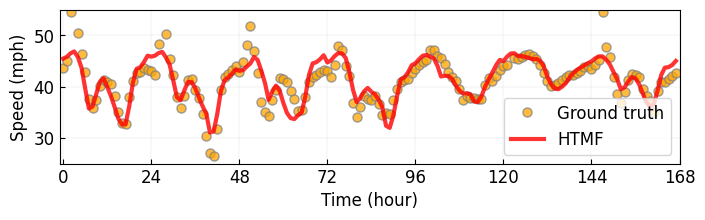

In [3]:
import matplotlib.pyplot as plt

pos = np.where(np.sum(dense_mat[:, - 7 * 24 :] > 0,
                      axis = 1) > 0.9 * 7 * 24)
print(len(pos[0]))
mat1 = dense_mat[pos[0], :]
mat2 = mat_hat[pos[0], :]

plt.rcParams['font.size'] = 12
fig = plt.figure(figsize = (8, 2))
ax = fig.add_subplot(1, 1, 1)
mat = np.zeros(7 * 24)
for i in range(7 * 24):
    pos = np.where(mat1[:, - 7 * 24 + i] > 0)
    mat[i] = np.mean(mat1[pos[0], - 7 * 24 + i])
plt.plot(np.asnumpy(np.where(mat > 0)[0]),
         np.asnumpy(mat[mat > 0]), 'o', markersize = 6.5, color = 'orange',
# plt.plot((np.where(mat > 0)[0]),
#          (mat[mat > 0]), 'o', markersize = 6.5, color = 'orange',
         markeredgecolor = 'gray',
         alpha = 0.75, label = 'Ground truth')
plt.plot(np.asnumpy(np.mean(mat2, axis = 0)),
# plt.plot((np.mean(mat2, axis = 0)),
         color = 'red', linewidth = 3,
         alpha = 0.8, label = 'HTMF')
plt.xticks(np.asnumpy(np.arange(0, 24 * 7 + 1, 1 * 24)))
# plt.xticks((np.arange(0, 24 * 7 + 1, 1 * 24)))
plt.xlabel('Time (hour)')
plt.ylabel('Speed (mph)')
plt.grid(axis = 'both', linestyle='dashed', linewidth = 0.1, color = 'gray')
ax.legend()
ax.tick_params(direction = "in")
ax.set_xlim([-1, 7 * 24])
ax.set_ylim([25, 55])
plt.show()
fig.savefig('forecasts_delta_{}.pdf'.format(delta), bbox_inches = 'tight')

Forecasting results of HTMF with `delta = 4`. These 14 example time series correspond to 14 road segments. The orange scatters indicate the observed speed values, while the red curves indicate the forecasts achieved by HTMF.

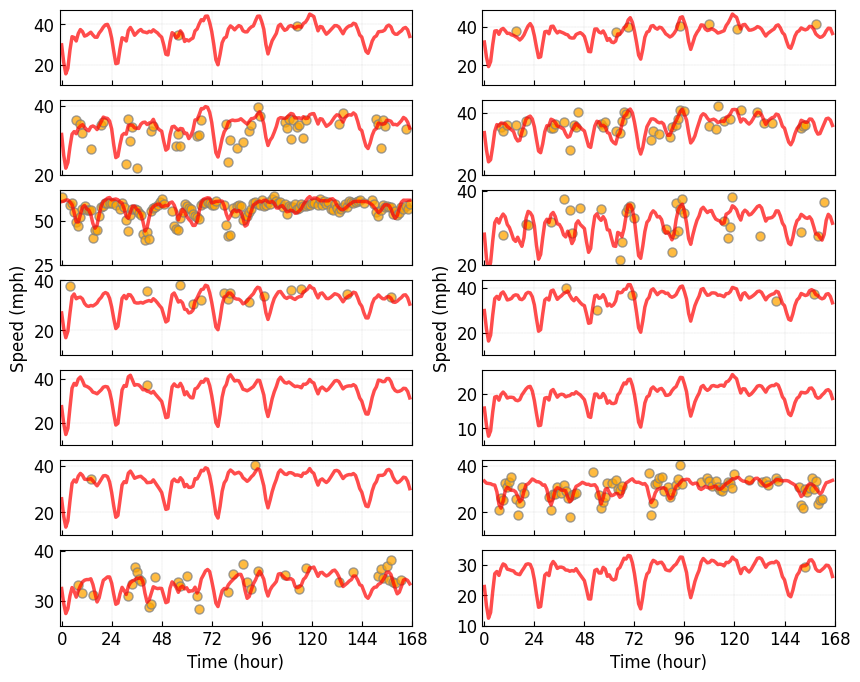

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 12
fig = plt.figure(figsize = (10, 8))
for loc in range(14):
    ax = fig.add_subplot(7, 2, loc + 1)
    plt.plot(np.asnumpy(dense_mat[loc, - 7 * 24 :]), 'o', markersize = 6.5,
    # plt.plot((dense_mat[loc, - 7 * 24 :]), 'o', markersize = 6.5,
             color = 'orange', markeredgecolor = 'gray', alpha = 0.75, label = 'Ground truth')
    plt.plot(np.asnumpy(mat_hat[loc, :]), color = 'red',
    # plt.plot((mat_hat[loc, :]), color = 'red',
             linewidth = 2.5, alpha = 0.7, label = 'HTMF')
    plt.xticks(np.asnumpy(np.arange(0, 24 * 7 + 1, 1 * 24)))
    # plt.xticks((np.arange(0, 24 * 7 + 1, 1 * 24)))
    if loc == 12 or loc == 13:
        plt.xlabel('Time (hour)')
    if loc == 6 or loc == 7:
        plt.ylabel('Speed (mph)')
    plt.grid(axis = 'both', linestyle='dashed', linewidth = 0.1, color = 'gray')
    ax.tick_params(direction = "in")
    ax.set_xlim([-1, 7 * 24])
    if loc < 12:
        plt.xticks(color = 'w')
    if loc == 12 or loc == 4:
        ax.set_ylim(bottom = 25)
    elif loc == 2 or loc == 3 or loc == 5:
        ax.set_ylim(bottom = 20)
    elif loc == 9:
        ax.set_ylim(bottom = 5)
    else:
        ax.set_ylim(bottom = 10)
plt.show()
fig.savefig('htmf_forecasts_delta_{}.pdf'.format(delta), bbox_inches = 'tight')

The histogram of ground truth data and forecasts achieved by HTMF with `delta = 4` in the test set. The missing rate implies the ratio of missing values of road segments in the test set.

741


<ipython-input-5-629187da6a7e>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat1[pos_new]), hist = False, kde = True,
<ipython-input-5-629187da6a7e>:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat2[pos_new]), hist = False, kde = True,


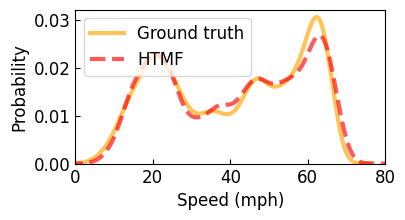

1650


<ipython-input-5-629187da6a7e>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat1[pos_new]), hist = False, kde = True,
<ipython-input-5-629187da6a7e>:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat2[pos_new]), hist = False, kde = True,


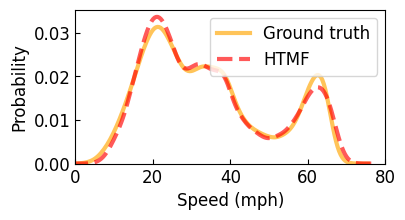

1432


<ipython-input-5-629187da6a7e>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat1[pos_new]), hist = False, kde = True,
<ipython-input-5-629187da6a7e>:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat2[pos_new]), hist = False, kde = True,


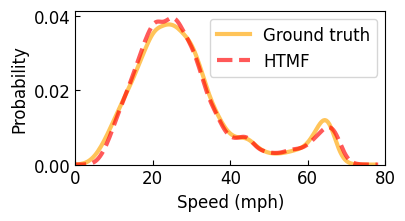

1551


<ipython-input-5-629187da6a7e>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat1[pos_new]), hist = False, kde = True,
<ipython-input-5-629187da6a7e>:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat2[pos_new]), hist = False, kde = True,


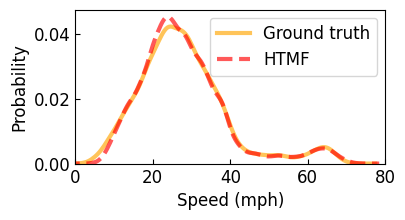

1712


<ipython-input-5-629187da6a7e>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat1[pos_new]), hist = False, kde = True,
<ipython-input-5-629187da6a7e>:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat2[pos_new]), hist = False, kde = True,


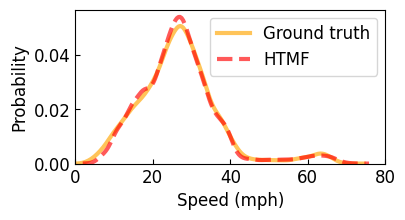

1769


<ipython-input-5-629187da6a7e>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat1[pos_new]), hist = False, kde = True,
<ipython-input-5-629187da6a7e>:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat2[pos_new]), hist = False, kde = True,


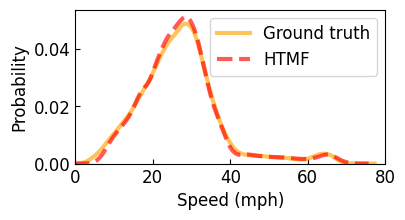

2076


<ipython-input-5-629187da6a7e>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat1[pos_new]), hist = False, kde = True,
<ipython-input-5-629187da6a7e>:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat2[pos_new]), hist = False, kde = True,


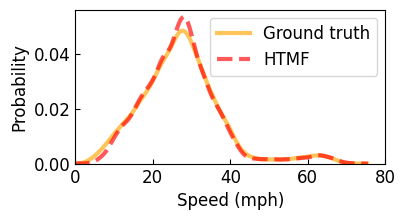

3365


<ipython-input-5-629187da6a7e>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat1[pos_new]), hist = False, kde = True,
<ipython-input-5-629187da6a7e>:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat2[pos_new]), hist = False, kde = True,


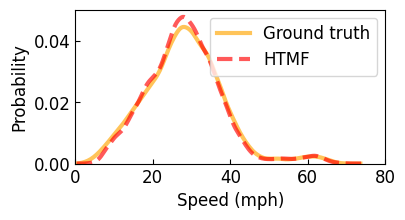

6602


<ipython-input-5-629187da6a7e>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat1[pos_new]), hist = False, kde = True,
<ipython-input-5-629187da6a7e>:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat2[pos_new]), hist = False, kde = True,


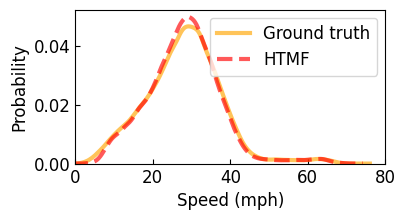

42592


<ipython-input-5-629187da6a7e>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat1[pos_new]), hist = False, kde = True,
<ipython-input-5-629187da6a7e>:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.asnumpy(mat2[pos_new]), hist = False, kde = True,


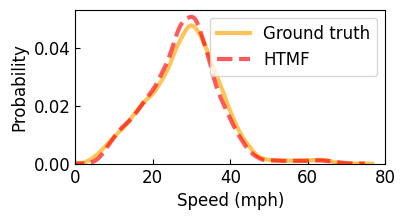

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

for k in range(1, 11):
    if k == 1:
        pos = np.where(np.sum(dense_mat[:, - 7 * 24 :] == 0, axis = 1) <= 0.1 * 7 * 24)
    elif k == 10:
        pos = np.where(np.sum(dense_mat[:, - 7 * 24 :] == 0, axis = 1) > 0.9 * 7 * 24)
    else:
        pos = np.where((np.sum(dense_mat[:, - 7 * 24 :] == 0, axis = 1) > 0.1 * (k - 1) * 7 * 24)
                       & (np.sum(dense_mat[:, - 7 * 24 :] == 0, axis = 1) <= 0.1 * k * 7 * 24))
    print(len(pos[0]))
    mat1 = dense_mat[pos[0], - 7 * 24 :]
    mat2 = mat_hat[pos[0], :]
    pos_new = np.where(mat1 > 0)

    plt.rcParams['font.size'] = 12
    fig = plt.figure(figsize = (4, 2))
    ax = fig.add_subplot(1, 1, 1)

    sns.distplot(np.asnumpy(mat1[pos_new]), hist = False, kde = True,
                  kde_kws = {'linewidth': 3, 'color': 'orange', 'alpha': 0.65},
                  label = 'Ground truth')
    sns.distplot(np.asnumpy(mat2[pos_new]), hist = False, kde = True,
                  kde_kws = {'linewidth': 3, 'linestyle':'--', 'color': 'red', 'alpha': 0.65},
                  label = 'HTMF')
    plt.tick_params(direction = "in")
    plt.xlim([0, 80])
    ax.legend(['Ground truth', 'HTMF'])
    plt.xlabel('Speed (mph)')
    plt.ylabel('Probability')
    plt.savefig('htmf_forecasts_hist_{}.pdf'.format(k), bbox_inches = 'tight')
    plt.show()

The variations of HTMF's loss functions with the iterations on different datasets.

In [10]:
import cupy as np

dense_mat = np.load('hourly_speed_mat_2019_1.npz')['arr_0']
for month in range(2, 4):
    dense_mat = np.append(dense_mat, np.load('hourly_speed_mat_2019_{}.npz'.format(month))['arr_0'], axis = 1)
dense_mat = dense_mat[:, : 24 * 7 * 10]

import time
converg = []
for week in [9, 8, 7, 6, 5, 4]:
    for rank in [30, 40, 50, 60]:
        for d in [24]: # order of VAR
            start = time.time()
            pred_step = 7 * 24
            maxiter = 50
            mat_hat, W, X, u, obf = hankel_tmf(dense_mat[:, 24 * 7 * (10 - week - 1) : 24 * 7 * 9],
                                               dense_mat[:, 24 * 7 * (10 - week - 1) : 24 * 7 * 9],
                                               rank, d, maxiter, obj = True)
            converg.append(obf)
            print('week = {}'.format(week))
            print('rank R = {}'.format(rank))
            print('Order d = {}'.format(d))
            end = time.time()
            print('Running time: %d seconds'%(end - start))
            print()

week = 9
rank R = 30
Order d = 24
Running time: 84 seconds

week = 9
rank R = 40
Order d = 24
Running time: 102 seconds

week = 9
rank R = 50
Order d = 24
Running time: 129 seconds

week = 9
rank R = 60
Order d = 24
Running time: 164 seconds

week = 8
rank R = 30
Order d = 24
Running time: 77 seconds

week = 8
rank R = 40
Order d = 24
Running time: 93 seconds

week = 8
rank R = 50
Order d = 24
Running time: 123 seconds

week = 8
rank R = 60
Order d = 24
Running time: 147 seconds

week = 7
rank R = 30
Order d = 24
Running time: 70 seconds

week = 7
rank R = 40
Order d = 24
Running time: 84 seconds

week = 7
rank R = 50
Order d = 24
Running time: 105 seconds

week = 7
rank R = 60
Order d = 24
Running time: 115 seconds

week = 6
rank R = 30
Order d = 24
Running time: 59 seconds

week = 6
rank R = 40
Order d = 24
Running time: 71 seconds

week = 6
rank R = 50
Order d = 24
Running time: 83 seconds

week = 6
rank R = 60
Order d = 24
Running time: 91 seconds

week = 5
rank R = 30
Order d = 24

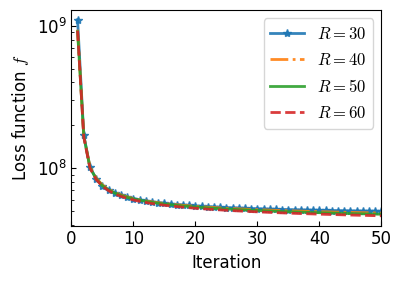

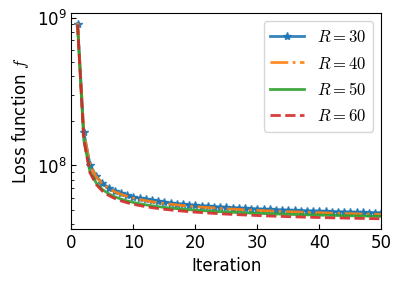

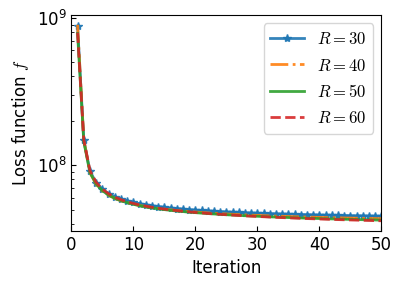

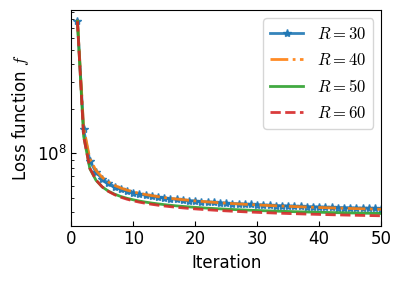

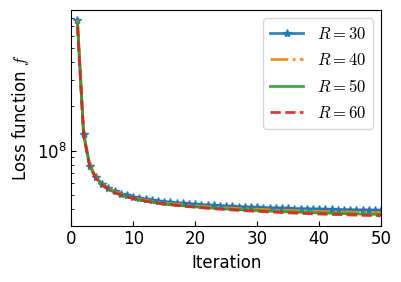

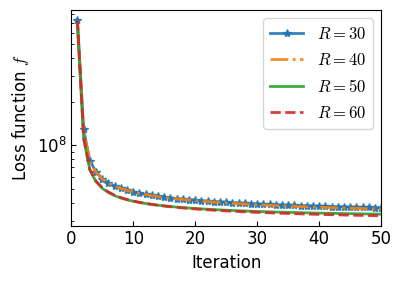

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'cm'

i = 0
for week in [9, 8, 7, 6, 5, 4]:
    fig = plt.figure(figsize = (4, 2.8))
    ax = fig.add_subplot(1, 1, 1)
    for k in range(4):
        if k == 0:
            plt.plot(np.asnumpy(np.arange(1, 51, 1)),
                    np.asnumpy(converg[2 * i + k]),
                    '-*', linewidth = 2, alpha = 0.9)
        if k == 1:
            plt.plot(np.asnumpy(np.arange(1, 51, 1)),
                    np.asnumpy(converg[2 * i + k]),
                    '-.', linewidth = 2, alpha = 0.9)
        if k == 2:
            plt.plot(np.asnumpy(np.arange(1, 51, 1)),
                    np.asnumpy(converg[2 * i + k]),
                    '-', linewidth = 2, alpha = 0.9)
        if k == 3:
            plt.plot(np.asnumpy(np.arange(1, 51, 1)),
                    np.asnumpy(converg[2 * i + k]),
                    '--', linewidth = 2, alpha = 0.9)
    plt.xlim([0, 50])
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel(r'Loss function $f$')
    plt.legend([r'$R = 30$', r'$R = 40$', r'$R = 50$', r'$R = 60$'])
    ax.tick_params(direction = "in")
    ax.tick_params(which = 'minor', direction = 'in')
    plt.show()
    fig.savefig('HTMF_loss_func_vs_iter_{}_weeks.pdf'.format(week), bbox_inches = 'tight')
    i += 1

Empirical time complexity of HTMF on the synthetic data. The HTMF model is tested 50 times on each randomly generated data, and average results are reported.

In [ ]:
import cupy as np
import time

N = int(1e+3)
T = np.arange(1, 11) * 1e+4
sample_no = 10
rank = 10
d = 10
time_mat1 = np.zeros((sample_no, 10))
for i in range(sample_no):
    k = 0
    for t in T:
        mat = np.random.randn(N, int(t))
        start = time.time()
        hankel_tmf(mat, mat, rank, d, 50)
        end = time.time()
        time_mat1[i, k] = end - start
        print('Running time: %d seconds'%(time_mat1[i, k]))
        k += 1
    print()

Running time: 7 seconds
Running time: 12 seconds
Running time: 19 seconds
Running time: 25 seconds
Running time: 31 seconds
Running time: 37 seconds
Running time: 43 seconds
Running time: 50 seconds
Running time: 56 seconds
Running time: 62 seconds

Running time: 6 seconds
Running time: 12 seconds
Running time: 18 seconds
Running time: 25 seconds
Running time: 31 seconds
Running time: 37 seconds
Running time: 43 seconds
Running time: 50 seconds
Running time: 56 seconds
Running time: 62 seconds

Running time: 6 seconds
Running time: 12 seconds
Running time: 18 seconds
Running time: 25 seconds
Running time: 31 seconds
Running time: 37 seconds
Running time: 43 seconds
Running time: 50 seconds
Running time: 56 seconds
Running time: 62 seconds

Running time: 6 seconds
Running time: 12 seconds
Running time: 18 seconds
Running time: 25 seconds
Running time: 31 seconds
Running time: 37 seconds
Running time: 43 seconds
Running time: 50 seconds
Running time: 56 seconds
Running time: 62 seconds



In [ ]:
import cupy as np
import time

N = int(1e+3)
T = np.arange(1, 11) * 1e+4
sample_no = 10
rank = 10
d = 20
time_mat2 = np.zeros((sample_no, 10))
for i in range(sample_no):
    k = 0
    for t in T:
        mat = np.random.randn(N, int(t))
        start = time.time()
        hankel_tmf(mat, mat, rank, d, 50)
        end = time.time()
        time_mat2[i, k] = end - start
        print('Running time: %d seconds'%(time_mat2[i, k]))
        k += 1
    print()

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'cm'

fig = plt.figure(figsize = (4, 2.8))
ax = fig.add_subplot(1, 1, 1)

power = time_mat1.shape[0]
plt.plot(np.asnumpy(np.mean(time_mat1, axis = 1)), '-o',
         color = 'r', alpha = 0.8, label = r'$d=10$')
lower_error = np.asnumpy(np.mean(time_mat1, axis = 1) - np.std(time_mat1, axis = 1))
upper_error = np.asnumpy(np.mean(time_mat1, axis = 1) + np.std(time_mat1, axis = 1))
x = np.append(0, np.append(np.arange(0, power), np.flip(np.arange(0, power))))
y = np.append(upper_error[0], np.append(lower_error, np.flip(upper_error)))
plt.fill(np.asnumpy(x), np.asnumpy(y), color = 'r', alpha = 0.15)

plt.plot(np.asnumpy(np.mean(time_mat2, axis = 1)), '-o',
         color = 'blue', alpha = 0.8, label = r'$d=20$')
lower_error = np.asnumpy(np.mean(time_mat2, axis = 1) - np.std(time_mat2, axis = 1))
upper_error = np.asnumpy(np.mean(time_mat2, axis = 1) + np.std(time_mat2, axis = 1))
x = np.append(0, np.append(np.arange(0, power), np.flip(np.arange(0, power))))
y = np.append(upper_error[0], np.append(lower_error, np.flip(upper_error)))
plt.fill(np.asnumpy(x), np.asnumpy(y), color = 'blue', alpha = 0.15)
ax.legend()

plt.xlabel(r'Data size ($\times 10^7$)')
plt.ylabel('Time (s)')
plt.xticks(np.arange(0, 10), np.arange(1, 11))
plt.xlim([-0.3, 9.3])
ax.tick_params(direction = 'in')
ax.tick_params(which = 'minor', direction = 'in')
ax.grid(color='gray', linestyle='dashed', linewidth=0.5, alpha=0.2)
plt.show()
fig.savefig('HTMF_empirical_time_complexity_curve.pdf', bbox_inches = 'tight')

The experiments were conducted using a hardware setup featuring a T4 GPU with 16GB of RAM.

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>